In [ ]:
from google.colab import files
files.upload()

Saving EEGModels.py to EEGModels (1).py


{'EEGModels (1).py': b'"""\r\n ARL_EEGModels - A collection of Convolutional Neural Network models for EEG\r\n Signal Processing and Classification, using Keras and Tensorflow\r\n\r\n Requirements:\r\n    (1) tensorflow == 2.X (as of this writing, 2.0 - 2.3 have been verified\r\n        as working)\r\n \r\n To run the EEG/MEG ERP classification sample script, you will also need\r\n\r\n    (4) mne >= 0.17.1\r\n    (5) PyRiemann >= 0.2.5\r\n    (6) scikit-learn >= 0.20.1\r\n    (7) matplotlib >= 2.2.3\r\n    \r\n To use:\r\n    \r\n    (1) Place this file in the PYTHONPATH variable in your IDE (i.e.: Spyder)\r\n    (2) Import the model as\r\n        \r\n        from EEGModels import EEGNet    \r\n        \r\n        model = EEGNet(nb_classes = ..., Chans = ..., Samples = ...)\r\n        \r\n    (3) Then compile and fit the model\r\n    \r\n        model.compile(loss = ..., optimizer = ..., metrics = ...)\r\n        fitted    = model.fit(...)\r\n        predicted = model.predict(...)\r\n\

In [ ]:
!pip install mne==1.9.0
!pip install tensorflow==2.18.0
!pip install tensorflow_privacy==0.9.0
!pip install scikit-learn==1.6.1

In [ ]:
!pip install --force-reinstall --no-cache-dir numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 162.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 22.0 which is incompatible.
xarray 2025.3.1 requires packaging>=23.2, but you have packaging 22.0 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline

from EEGModels import EEGNet
from EEGModels import DeepConvNet
from EEGModels import ShallowConvNet
from mne import Epochs, pick_types
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf

print(__doc__)

Automatically created module for IPython interactive environment


In [ ]:
import h5py
import time

In [ ]:
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

In [ ]:
start = time.time()

In [ ]:
# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1.0, 4.0
subjects = range(1,10)
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subjects, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)
raw.annotations.rename(dict(T1="hands", T2="feet"))  # as documented on PhysioNet
raw.set_eeg_reference(projection=True)

# Apply band-pass filter
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(
    raw,
    event_id=["hands", "feet"],
    tmin=tmin,
    tmax=tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2

Using default location ~/mne_data for EEGBCI...
Creating /root/mne_data


Do you want to set the path:
    /root/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n? y
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Download complete in 03m45s (66.2 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Used Annotations descriptions: ['T0', 'feet', 'hands']
Ignoring annotation durations and creating fixed-duration epochs around annotation onsets.
Not setting metadata
405 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 405 events and 801 original time points ...
0 bad epochs dropped


In [ ]:
# extract raw data. scale by 1000 due to scaling sensitivity in deep learning
X = epochs.get_data()*1000 # format is in (trials, channels, samples)
y = labels

kernels, chans, samples = 1, 64, 801

In [ ]:
print(X.shape, y.shape)

(405, 64, 801) (405,)


In [ ]:
X_train      = X[0:224,]
Y_train      = y[0:224]
X_validate   = X[224:320,]
Y_validate   = y[224:320]
X_test       = X[320:416]
Y_test       = y[320:416]

In [ ]:
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (224, 64, 801, 1)
224 train samples
85 test samples


In [ ]:
import os
os.makedirs('./tmp', exist_ok=True)

In [ ]:
model = DeepConvNet(nb_classes = 2, Chans = chans, Samples = samples, dropoutRate = 0.5)

# compile the model and set the optimizers
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
              metrics = ['accuracy'])

# count number of parameters in the model
numParams    = model.count_params()

# set a valid path for your system to record model checkpoints
with h5py.File('./tmp/mi_checkpoint.h5', 'w') as f:
    # This creates 2 attributes of arrays of different np.float types:
    arr_in = np.array([1.0,2.0,3.0])
    f.attrs['as_float64'] = arr_in
    # arr_in.dtype = np.float128
    # f.attrs['as_float128'] = arr_in
checkpointer = ModelCheckpoint(filepath='./tmp/mi_checkpoint.h5', verbose=1,
                               save_best_only=True)

###############################################################################
# if the classification task was imbalanced (significantly more trials in one
# class versus the others) you can assign a weight to each class during
# optimization to balance it out. This data is approximately balanced so we
# don't need to do this, but is shown here for illustration/completeness.
###############################################################################

# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
class_weights = {0:1, 1:1}

################################################################################
# fit the model. Due to very small sample sizes this can get
# pretty noisy run-to-run, but most runs should be comparable to xDAWN +
# Riemannian geometry classification (below)
################################################################################
fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 100,
                        verbose = 2, validation_data=(X_validate, Y_validate),
                        # callbacks=[checkpointer],
                        class_weight = class_weights)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
14/14 - 14s - 994ms/step - accuracy: 0.4777 - loss: 1.0903 - val_accuracy: 0.5104 - val_loss: 0.7012
Epoch 2/100
14/14 - 9s - 619ms/step - accuracy: 0.5580 - loss: 1.0399 - val_accuracy: 0.4896 - val_loss: 0.7079
Epoch 3/100
14/14 - 7s - 506ms/step - accuracy: 0.5759 - loss: 0.7945 - val_accuracy: 0.4896 - val_loss: 0.7361
Epoch 4/100
14/14 - 11s - 775ms/step - accuracy: 0.4955 - loss: 0.9247 - val_accuracy: 0.5104 - val_loss: 0.7162
Epoch 5/100
14/14 - 11s - 797ms/step - accuracy: 0.5670 - loss: 0.7004 - val_accuracy: 0.5521 - val_loss: 0.7011
Epoch 6/100
14/14 - 10s - 732ms/step - accuracy: 0.5759 - loss: 0.8150 - val_accuracy: 0.4792 - val_loss: 0.8359
Epoch 7/100
14/14 - 9s - 633ms/step - accuracy: 0.5759 - loss: 0.7501 - val_accuracy: 0.5104 - val_loss: 0.7079
Epoch 8/100
14/14 - 10s - 710ms/step - accuracy: 0.5938 - loss: 0.7535 - val_accuracy: 0.6146 - val_loss: 0.6674
Epoch 9/100
14/14 - 9s - 611ms/step - accuracy: 0.5893 - loss: 0.7719 - val_accuracy: 0.4583 - val_

In [ ]:
#load optimal weights
#model.load_weights('./tmp/mi_checkpoint.h5')

###############################################################################
# can alternatively used the weights provided in the repo. If so it should get
# you 93% accuracy. Change the WEIGHTS_PATH variable to wherever it is on your
# system.
###############################################################################

#WEIGHTS_PATH = "/path/to/EEGNet-8-2-weights.h5"
#model.load_weights(WEIGHTS_PATH)

###############################################################################
# make prediction on test set.
###############################################################################

probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 382ms/step
Classification accuracy: 0.635294 


In [ ]:



############################# PyRiemann Portion ##############################

# code is taken from PyRiemann's ERP sample script, which is decoding in
# the tangent space with a logistic regression

# n_components = 2  # pick some components

# # set up sklearn pipeline
# clf = make_pipeline(XdawnCovariances(n_components),
#                     TangentSpace(metric='riemann'),
#                     LogisticRegression())

# preds_rg     = np.zeros(len(Y_test))

# # reshape back to (trials, channels, samples)
# X_train      = X_train.reshape(X_train.shape[0], chans, samples)
# X_test       = X_test.reshape(X_test.shape[0], chans, samples)

# # train a classifier with xDAWN spatial filtering + Riemannian Geometry (RG)
# # labels need to be back in single-column format
# clf.fit(X_train, Y_train.argmax(axis = -1))
# preds_rg     = clf.predict(X_test)

# # Printing the results
# acc2         = np.mean(preds_rg == Y_test.argmax(axis = -1))
# print("Classification accuracy: %f " % (acc2))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

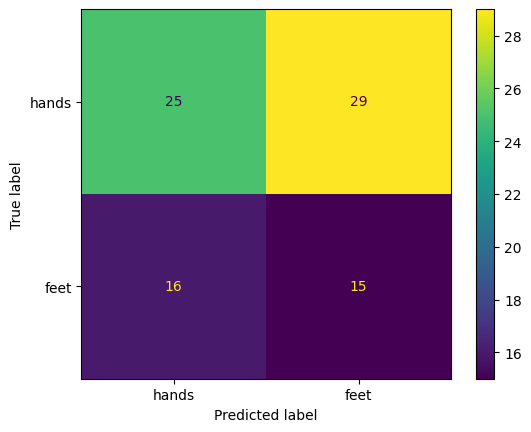

In [ ]:
# plot the confusion matrices for both classifiers
names        = ['hands', 'feet']
# plt.figure(0)
confusion_matrix_1 = confusion_matrix(preds, Y_test)

# plt.figure(1)
# confusion_matrix_2 = confusion_matrix(preds_rg, Y_test)

disp1 = ConfusionMatrixDisplay(confusion_matrix_1, display_labels = names)
disp1.plot()

# disp2 = ConfusionMatrixDisplay(confusion_matrix_2, display_labels = names)
# disp2.plot()

In [ ]:
print(classification_report(preds, Y_test))

              precision    recall  f1-score   support

           0       0.61      0.46      0.53        54
           1       0.34      0.48      0.40        31

    accuracy                           0.47        85
   macro avg       0.48      0.47      0.46        85
weighted avg       0.51      0.47      0.48        85



In [ ]:
end = time.time()
print(f"Took {end - start:.2f} seconds")

Took 1240.27 seconds


NameError: name 'compute_dp_sgd_privacy_lib' is not defined